# Исследование объявлений о продаже квартир

В вашем распоряжении данные сервиса Яндекс.Недвижимость — архив объявлений о продаже квартир в Санкт-Петербурге и соседних населённых пунктах за несколько лет. Нужно научиться определять рыночную стоимость объектов недвижимости. Ваша задача — установить параметры. Это позволит построить автоматизированную систему: она отследит аномалии и мошенническую деятельность.

По каждой квартире на продажу доступны два вида данных. Первые вписаны пользователем, вторые получены автоматически на основе картографических данных. Например, расстояние до центра, аэропорта, ближайшего парка и водоёма.

## Изучение данных из файла

In [1]:
import pandas as pd
from IPython.display import display

data = pd.read_csv('real_estate_data.csv')
display(data.head())

,total_images\tlast_price\ttotal_area\tfirst_day_exposition\trooms\tceiling_height\tfloors_total\tliving_area\tfloor\tis_apartment\tstudio\topen_plan\tkitchen_area\tbalcony\tlocality_name\tairports_nearest\tcityCenters_nearest\tparks_around3000\tparks_nearest\tponds_around3000\tponds_nearest\tdays_exposition
0,20\t13000000.0\t108.0\t2019-03-07T00:00:00\t3\...
1,7\t3350000.0\t40.4\t2018-12-04T00:00:00\t1\t\t...
2,10\t5196000.0\t56.0\t2015-08-20T00:00:00\t2\t\...
3,0\t64900000.0\t159.0\t2015-07-24T00:00:00\t3\t...
4,2\t10000000.0\t100.0\t2018-06-19T00:00:00\t2\t...


Данные склеились в одну строку вместо того, чтобы разбиться по колонкам. Чтобы разделить столбцы, передадим методу `read_csv()` параметр `sep='\t'`.

In [2]:
data = pd.read_csv('real_estate_data.csv', sep='\t')
display(data.head())
data.info()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
0,20,13000000.0,108.0,2019-03-07T00:00:00,3,2.70,16.0,51.0,8,NaN,...,25.0,NaN,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN
1,7,3350000.0,40.4,2018-12-04T00:00:00,1,NaN,11.0,18.6,1,NaN,...,11.0,2.0,посёлок Шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0
2,10,5196000.0,56.0,2015-08-20T00:00:00,2,NaN,5.0,34.3,4,NaN,...,8.3,0.0,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0
3,0,64900000.0,159.0,2015-07-24T00:00:00,3,NaN,14.0,NaN,9,NaN,...,NaN,0.0,Санкт-Петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424.0
4,2,10000000.0,100.0,2018-06-19T00:00:00,2,3.03,14.0,32.0,13,NaN,...,41.0,NaN,Санкт-Петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23699 non-null  int64  
 1   last_price            23699 non-null  float64
 2   total_area            23699 non-null  float64
 3   first_day_exposition  23699 non-null  object 
 4   rooms                 23699 non-null  int64  
 5   ceiling_height        14504 non-null  float64
 6   floors_total          23613 non-null  float64
 7   living_area           21796 non-null  float64
 8   floor                 23699 non-null  int64  
 9   is_apartment          2775 non-null   object 
 10  studio                23699 non-null  bool   
 11  open_plan             23699 non-null  bool   
 12  kitchen_area          21421 non-null  float64
 13  balcony               12180 non-null  float64
 14  locality_name         23650 non-null  object 
 15  airports_nearest   

### Вывод
В таблице 22 столбца и 23699 строчек. В каждой строчки таблицы - данные о квартире и ее продаже.

Согласно документации
- `airports_nearest` — расстояние до ближайшего аэропорта в метрах (м)
- `balcony` — число балконов
- `ceiling_height` — высота потолков (м)
- `cityCenters_nearest` — расстояние до центра города (м)
- `days_exposition` — сколько дней было размещено объявление (от публикации до снятия)
- `first_day_exposition` — дата публикации
- `floor` — этаж
- `floors_total` — всего этажей в доме
- `is_apartment` — апартаменты (булев тип)
- `kitchen_area` — площадь кухни в квадратных метрах (м²)
- `last_price` — цена на момент снятия с публикации
- `living_area` — жилая площадь в квадратных метрах (м²)
- `locality_name` — название населённого пункта
- `open_plan` — свободная планировка (булев тип)
- `parks_around3000` — число парков в радиусе 3 км
- `parks_nearest` — расстояние до ближайшего парка (м)
- `ponds_around3000` — число водоёмов в радиусе 3 км
- `ponds_nearest` — расстояние до ближайшего водоёма (м)
- `rooms` — число комнат
- `studio` — квартира-студия (булев тип)
- `total_area` — площадь квартиры в квадратных метрах (м²)
- `total_images` — число фотографий квартиры в объявлении

Только в 8 столбцах не встречается пропусков: `total_image`, `last_price`, `total_area`, `first_day_exposition`, `rooms`, `floor`, `studio`, `open_plan`. А в таких столбцах, как `is_apartment`, `park_nearest`, `ponds_nearest`, пропусков больше всего.

У половины столбцов тип данных не соответствует действительности. У столбцов `floor_total`, `balcony`, `parks_around300`, `ponds_around3000`, `days_exposition` тип данных `float64`, хотя по их природе он должен быть строго `int64`. Данные в столбцах `airports_nearest`, `cityCenters_nearest`, `park_nearest` и `ponds_nearest` могут быть числами с плавающей запятой, но для удобства для них тоже стоит изменить тип с `float64` на `int64`, тем более это никак не повлияет на результат исследования. У колонки `first_day_exposition` тип `object`, что не соответствует действительности и должен быть `datatime64`. И у столбца `is_apartment` также тип данных противоречит его природе, поэтому следует его изменить с `object` на `bool`.

В названии колонки `cityCenters_nearest` видно нарушение стиля.

Чтобы двигаться дальше, нужно устранить проблемы в данных.

## Предобработка данных

### Стиль заголовков
Переименуем столбец `'cityCenters_nearest'` в `'city_centers_nearest'`:

In [3]:
data.rename(columns={'cityCenters_nearest': 'city_centers_nearest'}, inplace=True)
data.columns

Index(['total_images', 'last_price', 'total_area', 'first_day_exposition',
       'rooms', 'ceiling_height', 'floors_total', 'living_area', 'floor',
       'is_apartment', 'studio', 'open_plan', 'kitchen_area', 'balcony',
       'locality_name', 'airports_nearest', 'city_centers_nearest',
       'parks_around3000', 'parks_nearest', 'ponds_around3000',
       'ponds_nearest', 'days_exposition'],
      dtype='object')

Сначала посчитаем количество пропущенных значений в таблице.

In [4]:
data.isna().sum()

total_images                0
last_price                  0
total_area                  0
first_day_exposition        0
rooms                       0
ceiling_height           9195
floors_total               86
living_area              1903
floor                       0
is_apartment            20924
studio                      0
open_plan                   0
kitchen_area             2278
balcony                 11519
locality_name              49
airports_nearest         5542
city_centers_nearest     5519
parks_around3000         5518
parks_nearest           15620
ponds_around3000         5518
ponds_nearest           14589
days_exposition          3181
dtype: int64

Сначала заполним пропуски в столбце `floor_total`. Пробелов в данных очень мало, вероятно они появились там из-за человеческого фактора (кто просто забыл заполнить эти данные). Будем заполнять пропуски медианным значением, если этаж, на котором находится квартира, меньше этого значения, в противном случае будем считать, что общее количество этажей равно этажу квартиры.

In [5]:
median_floors = data['floors_total'].median()

def total_floors(floor):
    return max(floor, median_floors)

mask = data['floors_total'].isna()
data.loc[mask, 'floors_total'] = data.loc[mask, 'floor'].apply(total_floors)

Пропусков в столбце `ceiling_height` много, почти 40%. Но так как высота потолков почти одинакова во всех квартирах и это значение не будет участвовать в проверке ни одной гипотезы, то заполним его медианой.

In [6]:
data['ceiling_height'].fillna(data['ceiling_height'].median(), inplace=True)

Следующими заполним пробелы в столбце `kitchen_area`, их встречается около 10%. Можно заметить закономерность: у студии (`studio = True`) нет площади кухни. С одной стороны это действительно так, так как в студии все комнаты объединены в одну, но с другой – по факту в каждой квартире есть кухня. У меньших квартир – меньшая кухня, у больших – бОльшая. Посмотрим, какое соотношение между площадью кухни и общей площадью квартиры.

In [7]:
kitchen_total_ratio = data['kitchen_area'] / data['total_area']
kitchen_total_ratio

0        0.231481
1        0.272277
2        0.148214
3             NaN
4        0.410000
           ...   
23694    0.103356
23695    0.144068
23696         NaN
23697    0.303583
23698    0.278638
Length: 23699, dtype: float64

Как видим, большинство кухонь занимают 0,15-0,2 площади всей квартиры. Посчитаем среднее и медиану, чтобы посмотреть подтверждаются ли наши наблюдения.

In [8]:
print(f'Среднее значение соотношения: {kitchen_total_ratio.mean()}')
print(f'Медиана соотношения: {kitchen_total_ratio.median()}')

Среднее значение соотношения: 0.1873547387717406
Медиана соотношения: 0.1724137931034483


Заполним пробелы в столбце `kitche_area` как `медиана соотношения * total_area`

In [9]:
data['kitchen_area'].fillna(kitchen_total_ratio.median() * data['total_area'], inplace=True)

С помощью такого же метода заполним пропуски в `living_area`:

In [10]:
living_total_ratio_median = (data['living_area'] / data['total_area']).median()
data['living_area'].fillna(living_total_ratio_median * data['total_area'], inplace=True)

Скорее всего, пробелы в колонке `balcony` возникли из-за того, что владельцы квартир без балконов просто игнорируют это поле в форме. Поэтому заполним `NaN` значения нулями.

In [11]:
data['balcony'].fillna(0, inplace=True)

В столбце `is_apartment` 88% пропусков. Это очень большой показатель, поэтому следует уточнить информацию об этих артефактах у разработчика. К сожалению, у нас нет такой возможности, поэтому будем делать предположения самостоятельно. Первое, что приходит в голову – это то, что столбцы `is_apartment`, `studio` и `open_plan` взаимоисключающие. Давайте это проверим:

In [12]:
(data['is_apartment'] + data['studio'] + data['open_plan']).value_counts()

0    2703
1      72
dtype: int64

Действительно, если хотя бы один из трех параметров – `True`, два других - `False`; таких комбинаций в таблице 72. Но также есть 2703 комбинаций, когда все три параметра ложны (`is_apartment == False and studio == False and open_plan == False`). Итак, мы можем заменить пропуски в `is_apartment` на `False`, где хотя бы один из двух других параметров (`studio`, `open_plan`) - `True`, но мы не можем заменить пропуски на `True`, где два других столбца - `False`. Поэтому логично нам будет заменить все пропуски в этом столбце на `False`.

In [13]:
data['is_apartment'].fillna(False, inplace=True)

В столбце `locality_name` пропусков менше 0.5%. Найти название населенного пункта мы не можем, поэтому остается два варианта: либо удалить строки, где есть пропуски, либо заменить `NaN` значения на маркер. Сделаем первый вариант:


In [14]:
data.dropna(subset=['locality_name'], inplace=True)
data.reset_index(drop=True, inplace=True)

Столбец `day_exposition` сообщает нам о том, сколько дней было размещено объявление. А если объявление все еще висит? В таком случае `NaN` значения вполне нормальное явление, поэтому мы ничего не будем делать с пропусками в этом столбце.

20% пропусков встречается в столбцах `airport_nearest`, `city_centers_nearest`, `parks_around3000`, `ponds_around3000` и 60% пропусков в столбцах `parks_nearest`, `ponds_nearest`. Если присмотреться к данным, то заметно, что пробелы по всем шести параметрам встречаются одновременно. Скорее всего, такое совпадение возникло из-за того, что была утрачена точная геолокация квартиры и программа не смогла автоматически просчитать эти данные. Но у нас все еще осталось название населенного пункта (`locality_name`) для этих квартир. Поэтому мы можем заполнить пробелы медианой каждой из групп населенного пункта.
Давайте посмотрим, какие уникальные значения в столбце `locality_name`:


In [15]:
data['locality_name'].value_counts()

Санкт-Петербург                    15721
посёлок Мурино                       522
посёлок Шушары                       440
Всеволожск                           398
Пушкин                               369
                                   ...  
поселок Каложицы                       1
посёлок Платформа 69-й километр        1
поселок Почап                          1
поселок Гончарово                      1
посёлок Дзержинского                   1
Name: locality_name, Length: 364, dtype: int64

В столбце встречаются неявные дубликаты, вызванные добавлением названия вида поселения к названию самого поселения. Например, <i>посёлок Мурино, поселок Мурино, Мурино</i>. Чтобы это устранить напишем функцию, которая будет со сроки названия населенного пункта оставлять только слово, написанное с прописной буквы (т.е. само название).

In [16]:
def get_locality_name(locality_name):
    return ' '.join([word for word in locality_name.split() if word[0].istitle()])

data['locality_name_unique'] = data['locality_name'].apply(get_locality_name)
data['locality_name_unique'].value_counts()

Санкт-Петербург    15721
Мурино               590
Кудрово              472
Шушары               440
Всеволожск           398
                   ...  
Пельгора               1
Каложицы               1
Платформа              1
Почап                  1
Дзержинского           1
Name: locality_name_unique, Length: 305, dtype: int64

Удалением дубликатов мы уменьшили количество уникальных значений почти на 20%. Теперь мы можем заполнить пробелы в столбцах `airport_nearest`, `city_centers_nearest`, `parks_around3000`, `ponds_around3000`, `parks_nearest`, `ponds_nearest`.

In [17]:
location_columns = ['airports_nearest', 'city_centers_nearest', 'parks_around3000', 'ponds_around3000', 'parks_nearest', 'ponds_nearest']

def get_value(row, column, medians):
    if pd.isna(row[column]):
        return medians.loc[row['locality_name_unique']]
    return row[column]

for col in location_columns:
    medians_data = data.groupby('locality_name_unique')[col].median()
    data[col] = data.apply(lambda row: get_value(row, col, medians_data), axis=1)

data.isna().sum()

total_images               0
last_price                 0
total_area                 0
first_day_exposition       0
rooms                      0
ceiling_height             0
floors_total               0
living_area                0
floor                      0
is_apartment               0
studio                     0
open_plan                  0
kitchen_area               0
balcony                    0
locality_name              0
airports_nearest        4829
city_centers_nearest    4829
parks_around3000        4829
parks_nearest           5998
ponds_around3000        4829
ponds_nearest           4938
days_exposition         3180
locality_name_unique       0
dtype: int64

Хотя пропуски все еще остались, нам удалось заполнить более 600 пробелов для каждого столбца. Заполнять оставшиеся пропуски какими-то конкретными данными нет смысла, так как это может только испортить общую картину.

### Замена типа данных

Давайте посмотрим еще раз на типы данных.

In [18]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23650 entries, 0 to 23649
Data columns (total 23 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23650 non-null  int64  
 1   last_price            23650 non-null  float64
 2   total_area            23650 non-null  float64
 3   first_day_exposition  23650 non-null  object 
 4   rooms                 23650 non-null  int64  
 5   ceiling_height        23650 non-null  float64
 6   floors_total          23650 non-null  float64
 7   living_area           23650 non-null  float64
 8   floor                 23650 non-null  int64  
 9   is_apartment          23650 non-null  bool   
 10  studio                23650 non-null  bool   
 11  open_plan             23650 non-null  bool   
 12  kitchen_area          23650 non-null  float64
 13  balcony               23650 non-null  float64
 14  locality_name         23650 non-null  object 
 15  airports_nearest   

Колонки `airports_nearest`, `city_centers_nearest`, `parks_around3000`, `parks_nearest`, `ponds_around3000`, `ponds_nearest` содержат `NaN`, который относится к `float`, поэтому мы не будем изменять тип в этих столбцах. А вот для колонок `last_price`, `total_area`, `floors_total`, `living_area`, `kitchen_area`, `balcony` изменим тип с `float` на `int`. Также изменим тип даты, чтобы было удобнее с ней работать.

In [19]:
float_columns = ['last_price', 'total_area', 'floors_total', 'living_area', 'kitchen_area', 'balcony', 'rooms']

for col in float_columns:
    data[col] = data[col].astype('int')

data['first_day_exposition'] = pd.to_datetime(
    data['first_day_exposition'], format='%Y-%m-%dT%H:%M:%S'
)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23650 entries, 0 to 23649
Data columns (total 23 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   total_images          23650 non-null  int64         
 1   last_price            23650 non-null  int64         
 2   total_area            23650 non-null  int64         
 3   first_day_exposition  23650 non-null  datetime64[ns]
 4   rooms                 23650 non-null  int64         
 5   ceiling_height        23650 non-null  float64       
 6   floors_total          23650 non-null  int64         
 7   living_area           23650 non-null  int64         
 8   floor                 23650 non-null  int64         
 9   is_apartment          23650 non-null  bool          
 10  studio                23650 non-null  bool          
 11  open_plan             23650 non-null  bool          
 12  kitchen_area          23650 non-null  int64         
 13  balcony         

Все необходимые типы изменены.

### Обработка дубликатов

Проверим данные на наличие дубликатов.


In [20]:
data.duplicated().sum()

0

Дубликатов в данных нет.

## Расчёты и добавление результатов в таблицу

Посчитаем цену квадратного метра:

In [21]:
data['price_m2'] = data['last_price'] / data['total_area']

Узнаем и добавим в таблицу день недели, месяц и год публикации объявления:

In [22]:
data['weekday'] = data['first_day_exposition'].dt.day_name()
data['month'] = data['first_day_exposition'].dt.month_name()
data['year'] = data['first_day_exposition'].dt.year

Категоризируем этаж квартиры - <i>первый, последний, другой</i>.

In [23]:
def get_floor_category(row):
    if row['floor'] == 1:
        return 'первый'
    elif row['floor'] == row['floors_total']:
        return 'последний'
    return 'другой'

data['floor_category'] = data.apply(get_floor_category, axis=1)

Посчитаем соотношение жилой и общей площади, а также отношение площади кухни к общей.

In [24]:
data['living_total_area_ratio'] = data['living_area'] / data['total_area']
data['kitchen_total_area_ratio'] = data['kitchen_area'] / data['total_area']

## Исследовательский анализ данных

array([[<AxesSubplot:title={'center':'ceiling_height'}>]], dtype=object)

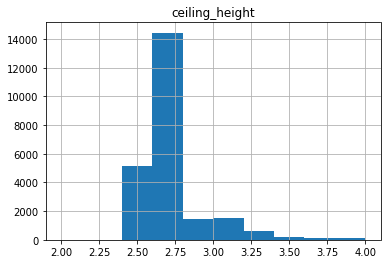

In [33]:
#data.hist('total_area', bins=20)
#data.hist('last_price', bins=50, range=(0, 0.5e8))
#print(data.info())
#data.plot(y='rooms', kind='hist')
#print(data['rooms'].describe())
data.hist('ceiling_height', range=(2, 4))

array([[<AxesSubplot:title={'center':'days_exposition'}>]], dtype=object)

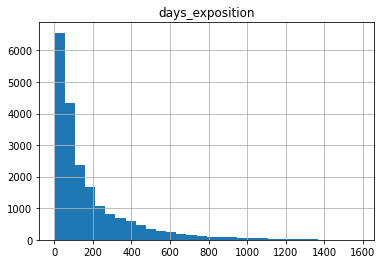

In [26]:
data.hist('days_exposition', bins=30)

<AxesSubplot:>

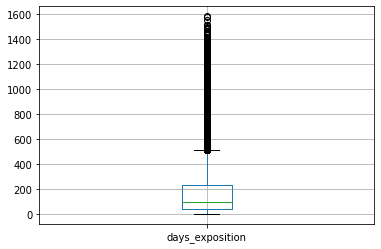

In [36]:
data['days_exposition'].describe()
data.boxplot(column='days_exposition')